# Pacotes

In [3]:

# Conection Data
from google.cloud import bigquery # conexão banco de dados
from google.oauth2 import service_account # conexão banco de dados
from pandas.io import gbq # conexão banco de dados

# Tratament Data
import pandas as pd  # biblioteca para trabalhar com dataframes e realizar ETL
import numpy as np  # biblioteca para trabalhar com arrays
import statsmodels.api as sm  # biblioteca para explorar, estimar e testar dados e modelos estatísticos 
from datetime import date, timedelta, datetime  # biblioteca para trabalhar com datas
from dateutil.relativedelta import relativedelta  # biblioteca de extensão do datetime
from scipy import stats  # biblioteca de computação científica
from pandas import DataFrame 

# Graphics
import matplotlib.pyplot as plt  #biblioteca para criar gráficos "comuns" ao estilo Matlab.
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

# Tratament Models
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Models Machine Learnig
from sklearn.linear_model import LogisticRegression  # Regressão Logit do sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics Models
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

# Pipeline Model
from sklearn.pipeline import Pipeline, make_pipeline

# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV

# Load Dataset

In [4]:
# Credenciais Google Cloud

credentials = service_account.Credentials.from_service_account_file(filename='/home/oem/apps/crendentials/ContaServicoBigQuery.json', 
                                                                    scopes=["https://www.googleapis.com/auth/cloud-platform"])
client = bigquery.Client(credentials=credentials)
# Query SQL
sql = """
SELECT
  CASE
    WHEN ra.nota < 4 THEN "Negativo"
    WHEN ra.nota  >= 7 THEN "Positivo"
    END AS sentimento,
  ra.tempo_reclamacao,
  ra.status,
  REGEXP_CONTAINS(ra.titulo, r'Seguro|seguro|Seguros|seguros|Sinistro|sinistro|Sinitros|sinistros|Carro|carro|Carros|Carro|Proteção|proteção|Proteções|proteções|Atendimento|atendimento|Atendimentos|atendimentos') AS token_positivo,
  REGEXP_CONTAINS(ra.titulo, r'Seguro|seguro|Seguros|seguros|Prestamista|prestamista|Prestamistas|prestamistas|Sinistro|sinistro|Sinitros|sinistros|Cancelamento|cancelamento|Cancelamentos|cancelamento|Reembolso|reembolso|Reembolsos|reembolsos') AS token_negativo
FROM `braided-upgrade-355410.ReclameAquiStage.reclamacoes` as ra
WHERE ra.nota > 7 OR ra.nota < 4 
"""


In [5]:
# carrega dataset
dataset = client.query(sql).to_dataframe()

In [6]:
# copy

df = dataset.copy()

In [7]:
# verificando o dataset

df.head()

,sentimento,tempo_reclamacao,status,token_positivo,token_negativo
0,Negativo,4,Não resolvido,False,False
1,Negativo,13,Não resolvido,False,True
2,Negativo,15,Não resolvido,True,True
3,Negativo,15,Não resolvido,False,False
4,Negativo,16,Resolvido,False,False


In [8]:
print('Amostras e Features', df.shape)
print('Columns: ', df.dtypes)

Amostras e Features (1418, 5)
Columns:  sentimento           object
tempo_reclamacao      Int64
status               object
token_positivo      boolean
token_negativo      boolean
dtype: object


# Removendo Outliers

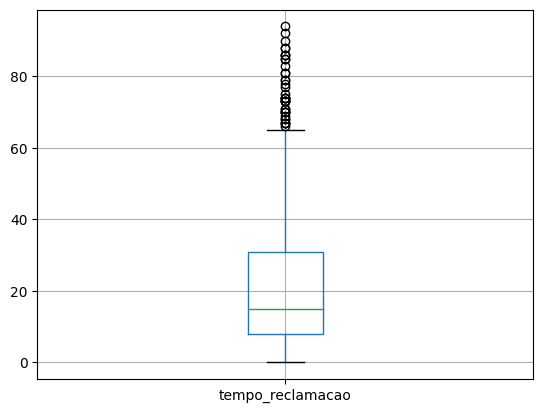

In [9]:
#verificando se existem outliers (anomalias) usando o boxblot

boxplot = df.boxplot(column=['tempo_reclamacao'])

In [10]:
def remove_outliers(columns: list, qtd_desvios: int, df: DataFrame) -> DataFrame:
    
    for column in columns:
        
        quartil_01 = df[column].quantile(q=0.25)
        quartil_03 = df[column].quantile(q=0.75)
        amplitude = quartil_03 - quartil_01
        
        print(f'''
        Coluna: {column}
        Tamanho Inicial: {df.shape[0]}
        ''')
        
        # df = df.loc[~df.index.isin(list(result[0]))]
        
        df = df.loc[
            (df[column] > (quartil_01 - 1.5 * amplitude)) &
            (df[column] < (quartil_03 + 1.5 * amplitude))
        ]
        
        print(f'''
        Tamanho Final: {df.shape[0]}
        ##########################################
        ''')
        
    return df

In [11]:
df2 = remove_outliers(['tempo_reclamacao'], 1, df)


        Coluna: tempo_reclamacao
        Tamanho Inicial: 1418
        

        Tamanho Final: 1379
        ##########################################
        


# Dummies

Para a transformão iremos utilizar dois metódos:

dummy: transformar uma variavel categorica com valores 0 e 1.

combinação de recursos: na combinação de recursos pegaremos duas variavies categóricas semelhante e combinaremos em uma única variável.


In [12]:
df3 = df2.copy()

In [13]:
df3['sentimento'].replace({'Positivo':'1',
                            'Negativo':'0'},inplace=True)

In [14]:
df3.groupby(by=['sentimento']).count()

,tempo_reclamacao,status,token_positivo,token_negativo
sentimento,,,,
0,967,967,967,967
1,412,412,412,412


In [15]:
df3['sentimento'] = df3['sentimento'].astype(int)

In [16]:
df3['status'].replace({'Resolvido':'1',
                            'Não resolvido':'0'},inplace=True)

In [17]:
df3.groupby(by=['status']).count()

,sentimento,tempo_reclamacao,token_positivo,token_negativo
status,,,,
0,679,679,679,679
1,700,700,700,700


In [18]:
df3['status'] = df3['status'].astype(int)

# Analisando a multicolinearidade

In [19]:
df3.dtypes

sentimento            int64
tempo_reclamacao      Int64
status                int64
token_positivo      boolean
token_negativo      boolean
dtype: object

In [20]:
# verificando multicolinearidade
# VIF 
vif_df = pd.DataFrame() 
vif_df['var'] = df3.columns

# Calculando o VIF para cada variável

vif_df["VIF"] = [variance_inflation_factor(np.array(df3.values, dtype=float), i) 
                          for i in range(len(df3.columns))] 

print(vif_df)

                var       VIF
0        sentimento  2.389501
1  tempo_reclamacao  1.646036
2            status  2.974743
3    token_positivo  2.724090
4    token_negativo  2.754431


In [21]:
df4 = df3.copy()

# Correlação

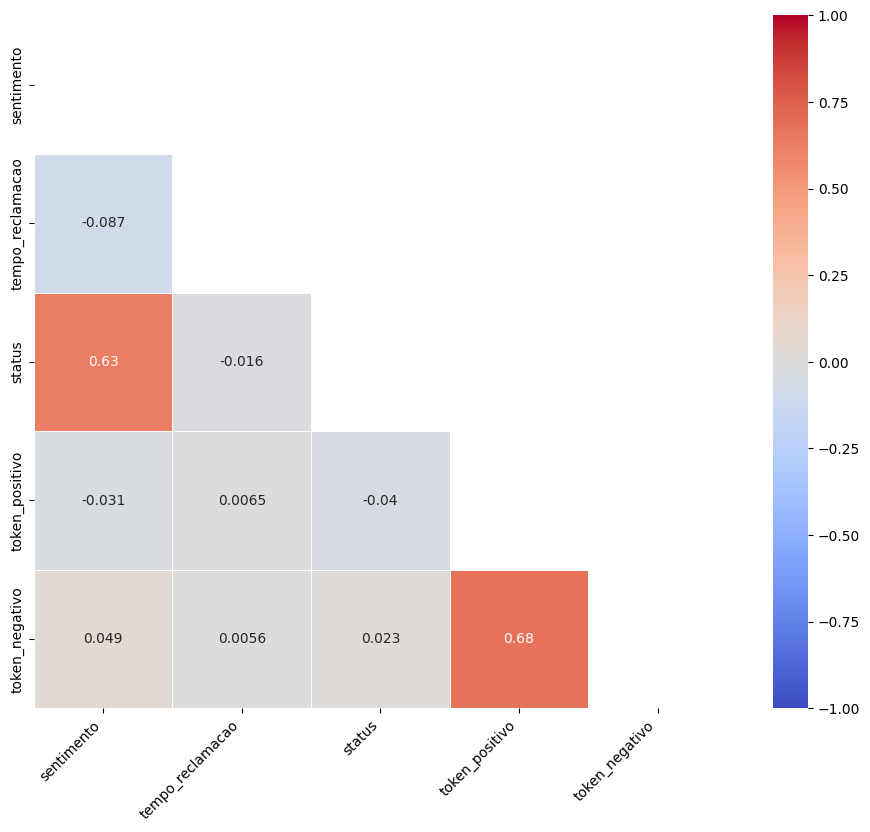

In [22]:

import matplotlib.pyplot as plt


plt.figure(figsize=(12,9))
corr = df4.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(
    corr,
    annot=True,
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    square=True,
    mask = mask,
    linewidths=.5
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

# Splitting the dataset into the Training set and Test set

In [23]:
# separando os dados em treino e teste
X = df4.loc[:, df4.columns != 'sentimento']
y = df4.loc[:, df4.columns == 'sentimento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# salvando as variaveis xn
columns = X_train.columns

In [24]:
X_train = X_train.astype(int, errors='ignore')

In [25]:
X_train.head()

,tempo_reclamacao,status,token_positivo,token_negativo
611,17,0,0,1
447,43,0,0,0
964,58,0,1,1
338,4,1,0,0
1401,44,1,0,0


In [26]:
y_train =  y_train.astype(int, errors='ignore')

In [27]:
y_train.head()

,sentimento
611,0
447,0
964,0
338,0
1401,1


# Feature Scaling - Padronização de Valores

Utilizamos a padronização de valores quando temos valores muitos descrepetantes. Desta forma, os valores são transformados em um intervalo de -3 a 3.

*Obs*: caso os valores já estiveram no intervalo de -3 a 3 não será necessário padronizalos.

In [28]:
dados_num = X_train.loc[:,['tempo_reclamacao']]
scraler = StandardScaler()
X_train['tempo_reclamacao'] = StandardScaler().fit_transform(dados_num)

In [29]:
X_train.head()

,tempo_reclamacao,status,token_positivo,token_negativo
611,-0.188394,0,0,1
447,1.536665,0,0,0
964,2.531891,0,1,1
338,-1.050923,1,0,0
1401,1.603013,1,0,0


# Balanceamento

In [30]:
# Aplicando o metodo SMOTE
os = SMOTE(random_state=0)

# modelando em cima dos dados de treino
os_data_X,os_data_y= os.fit_resample(X_train, y_train)

In [31]:
print("Tamanho da Amostra final: ",len(os_data_X))
print("Quantidade de sentimentos negativos", len(os_data_y[os_data_y['sentimento']==0]))
print("Quantidade de sentimentos positivos", len(os_data_y[os_data_y['sentimento']==1]))
print("Proporcao de sentimentos negativos",len(os_data_y[os_data_y['sentimento']==0])/len(os_data_X))
print("Proporcao de sentimentos positivos",len(os_data_y[os_data_y['sentimento']==1])/len(os_data_X))

Tamanho da Amostra final:  1408
Quantidade de sentimentos negativos 704
Quantidade de sentimentos positivos 704
Proporcao de sentimentos negativos 0.5
Proporcao de sentimentos positivos 0.5


# Train - Model 1

## XGBOOST


In [40]:
classifier = XGBClassifier(random_state=1)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [41]:
y_pred = classifier.predict(X_test)

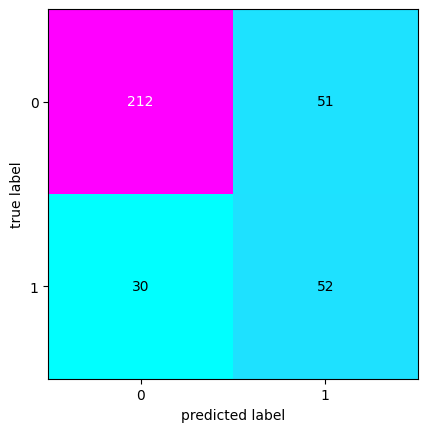

In [42]:
matriz_confusao = confusion_matrix(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao, cmap='cool')
plt.show()

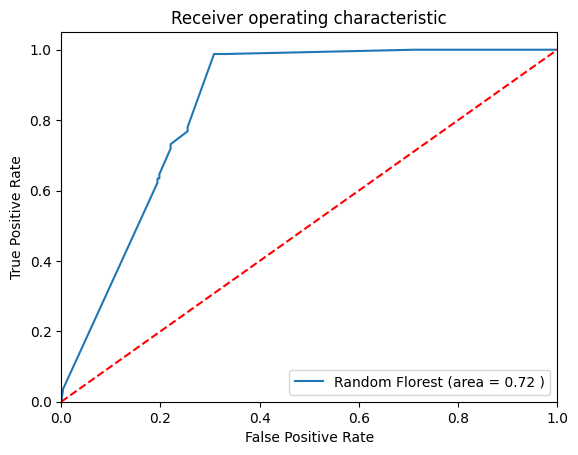

In [43]:
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Florest (area = %0.2f )' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [44]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.5048543689320388

Recall
 0.6341463414634146

F1
 0.5621621621621622

AUCROC
 0.7201149958267644


### Grid Search

In [57]:
parameters = { 
    'model__max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'model__learning_rate': [0.001, 0.01, 0.1, 0.20, 0.25, 0.30],
    "model__gamma":[0, 0.25, 0.5, 0.75,1],
    'model__n_estimators': [100, 500, 1000],
    "model__subsample":[0.9],
    "model__colsample_bytree":[0.5],
    "model__early_stopping_rounds": [10]
}

In [58]:
# Define grid search
grid_boost = GridSearchCV(estimator=XGBClassifier(random_state = 1), 
                           param_grid=parameters, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=10, 
                           verbose=0)
# Fit grid search
grid_result =  grid_boost.fit(X_train, y_train)
# Print grid search summary
grid_result
# Print the best score and the corresponding hyperparameters
print(f'The best score is {grid_result.best_score_:.4f}')
print(f'The best hyperparameters are {grid_result.best_params_}')

[22:11:44] WARNING: ../src/learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__early_stopping_rounds", "model__gamma", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__subsample" } are not used.

[22:11:44] WARNING: ../src/learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__early_stopping_rounds", "model__gamma", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__subsample" } are not used.

[22:11:44] WARNING: ../src/learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__early_stopping_rounds", "model__gamma", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__subsample" } are not used.
[22:11:44] WARNING: ../src/learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__early_stopping_rounds", "model__gamma", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__subsample" } are not used.


[22:11:44] WARNING: ../src/learner.cc:767: 
Parameters: 

In [59]:
y_pred =grid_boost.predict(X_test)

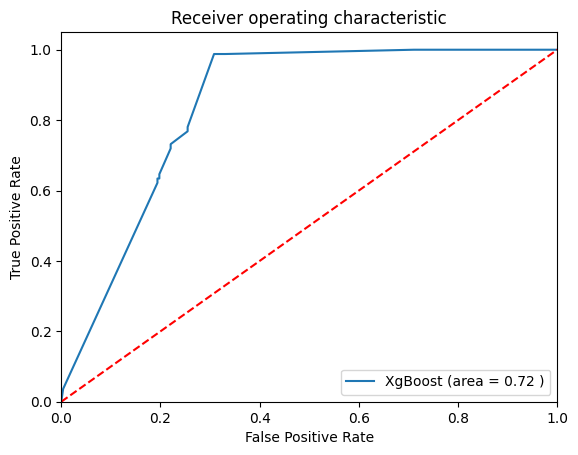

In [62]:
logit_roc_auc = roc_auc_score(y_test, grid_boost.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, grid_boost.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XgBoost (area = %0.2f )' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [61]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.5048543689320388

Recall
 0.6341463414634146

F1
 0.5621621621621622

AUCROC
 0.7201149958267644
